In [1]:
#Optimizing EV in SVD basis give ~ the same results as NS ISMARA_alpha_snRNA-seq_v1.ipynb

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error, explained_variance_score
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
from utils_plot import *
from scipy.optimize import minimize_scalar

In [3]:
# 1. Data Normalization

def preprocessing(alpha1, alpha2, N, ampl_threshold=0):

    targetnames = np.array(list(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
    
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    N_norm = N - np.mean(N, axis=0, keepdims=True)

    return alpha1_norm, alpha2_norm, N_norm, targetnames_filtered, tf_names_filtered

In [4]:
def svd_regression_solutions(E, N, alphas, sigma2=0):
    """
    Fit SVD-based regression model for a range of regularization strengths (alphas).
    Returns a list of fitted coefficient matrices A for each alpha.
    sigma2 is an indicator of how much we want to trust the data. (Apparently best is sigma2=0)
    """
    U, s, VT = np.linalg.svd(N, full_matrices=False)
    UT_E = U.T @ E
    models = []

    for alpha in alphas:
        denom = sigma2 + (s**2) / alpha
        X = (s / denom)[:, np.newaxis] * UT_E
        A = VT.T @ X
        models.append(A)

    return models

In [5]:
def svd_lambda_optimization(alpha1, alpha2, N, lam_candidates):
    """
    Cross-validate and plot model performance for various alphas (lambdas) using SVD regression.
    """
    EV_train, EV_test = [], []
    MSE_train, MSE_test = [], []

    # 2-fold cross-validation
    for train_alpha, test_alpha in [(alpha1, alpha2), (alpha2, alpha1)]:
        EV_train_fold, EV_test_fold = [], []
        MSE_train_fold, MSE_test_fold = [], []

        models = svd_regression_solutions(train_alpha, N, lam_candidates)

        for A in models:
            R = N @ A

            EV_train_fold.append(explained_variance_score(train_alpha, R))
            EV_test_fold.append(explained_variance_score(test_alpha, R))

            MSE_train_fold.append(mean_squared_error(train_alpha, R))
            MSE_test_fold.append(mean_squared_error(test_alpha, R))

        EV_train.append(EV_train_fold)
        EV_test.append(EV_test_fold)
        MSE_train.append(MSE_train_fold)
        MSE_test.append(MSE_test_fold)

    # Convert to arrays for averaging
    EV_train = np.array(EV_train)
    EV_test = np.array(EV_test)
    MSE_train = np.array(MSE_train)
    MSE_test = np.array(MSE_test)

    avg_EV_test = np.mean(EV_test, axis=0)
    avg_MSE_test = np.mean(MSE_test, axis=0)

    # Best lambda based on test EV
    best_index = np.argmax(avg_EV_test)
    best_lam = lam_candidates[best_index]
    best_EV = avg_EV_test[best_index]
    best_MSE = avg_MSE_test[best_index]

    # Plotting
    plt.figure(figsize=(12, 5))

    # EV plot
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(lam_candidates, EV_train[i], '--', color='green', alpha=0.6, label=f"Train Fold {i+1}")
        plt.plot(lam_candidates, EV_test[i], '--', color='orange', alpha=0.6, label=f"Test Fold {i+1}")
    plt.plot(lam_candidates, avg_EV_test, 'o-', color='black', label="Avg Test")
    plt.xscale("log")
    plt.xlabel("Lambda (Alpha)")
    plt.ylabel("Explained Variance")
    plt.title("Explained Variance vs Lambda")
    plt.legend()
    plt.grid(True)

    # MSE plot
    plt.subplot(1, 2, 2)
    for i in range(2):
        plt.plot(lam_candidates, MSE_train[i], '--', color='blue', alpha=0.6, label=f"Train Fold {i+1}")
        plt.plot(lam_candidates, MSE_test[i], '--', color='magenta', alpha=0.6, label=f"Test Fold {i+1}")
    plt.plot(lam_candidates, avg_MSE_test, 'o-', color='black', label="Avg Test")
    plt.xscale("log")
    plt.xlabel("Lambda (Alpha)")
    plt.ylabel("Mean Squared Error")
    plt.title("MSE vs Lambda")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return best_lam, best_EV, best_MSE

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360)


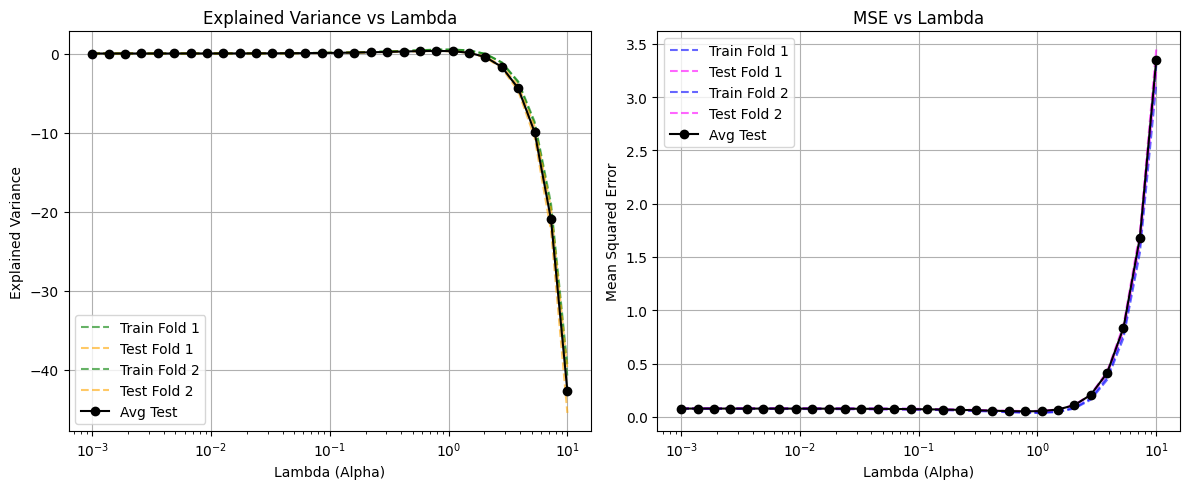

Best lambda: 0.7880, EV: 0.332, MSE: 0.051


In [6]:
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
lam_candidates = np.logspace(-3, 1, 30)

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.2
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape)

best_lam, best_EV, best_MSE = svd_lambda_optimization(alpha1_norm, alpha2_norm, N_norm, lam_candidates)

print(f"Best lambda: {best_lam:.4f}, EV: {best_EV:.3f}, MSE: {best_MSE:.3f}")

A1 = svd_regression_solutions(alpha1_norm, N_norm, [best_lam])[0]
A2 = svd_regression_solutions(alpha2_norm, N_norm, [best_lam])[0]

In [7]:
#A, alpha_train, alpha_test, R = train_best_model(alpha1_norm, alpha2_norm, N_norm, best_lam)*
R1 = N_norm @ A1
print("EV_train :", round(explained_variance_score(alpha1_norm, R1)*100,2), "%", "MSE_train :", round(mean_squared_error(alpha1_norm, R1),2))
print("EV_test :", round(explained_variance_score(alpha2_norm, R1)*100,2), "%", "MSE_test :", round(mean_squared_error(alpha2_norm, R1),3), "\n")
R2 = N_norm @ A2
print("EV_train :", round(explained_variance_score(alpha2_norm, R2)*100,2), "%", "MSE_train :", round(mean_squared_error(alpha2_norm, R2),2))
print("EV_test :", round(explained_variance_score(alpha1_norm, R2)*100,2), "%", "MSE_test :", round(mean_squared_error(alpha1_norm, R2),3), "\n")

EV_train : 47.13 % MSE_train : 0.04
EV_test : 33.92 % MSE_test : 0.048 

EV_train : 48.81 % MSE_train : 0.04
EV_test : 32.45 % MSE_test : 0.054 



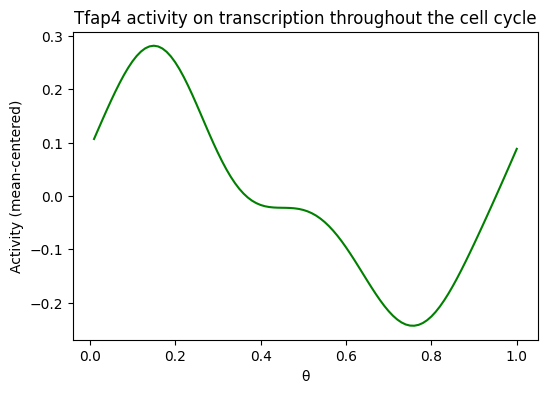

In [8]:
BP_nb = np.where(tf_names == 'Tfap4')[0][0]
plot_binding_protein_activity(tf_names, A1, process, theta_smooth, BP_nb=BP_nb)

In [9]:
tf_names

Index(['Ahr', 'Aire', 'Arid3a', 'Arid5b', 'Arnt', 'Arnt2',
       'Arntl_Tfe3_Mlx_Mitf_Mlxipl_Tfec', 'Ascl2', 'Atf1_Creb5', 'Atf3',
       ...
       'Zbtb7a', 'Zbtb7b', 'Zbtb7c', 'Zfhx3', 'Zfp128', 'Zfp263', 'Zfp652',
       'Zfx_Mecp2', 'Zkscan1', 'Zkscan3'],
      dtype='object', length=360)

['Grhl1' 'Olig3_Atoh1_Bhlhe23' 'Smad2' 'Cbfb' 'Hdx' 'Prox1' 'Hoxa3' 'Maff'
 'Rest' 'Barhl1' 'Pou6f2_Pou4f2' 'Hoxb2_Dlx2' 'Sox21' 'Rora' 'Gata4'
 'Hoxa7_Hoxc8' 'Sox30' 'Nfatc4' 'Nr4a3' 'Klf3' 'Hoxb4' 'Thrb' 'Gata6'
 'Foxd3' 'Mnx1_Lhx6_Lmx1a']


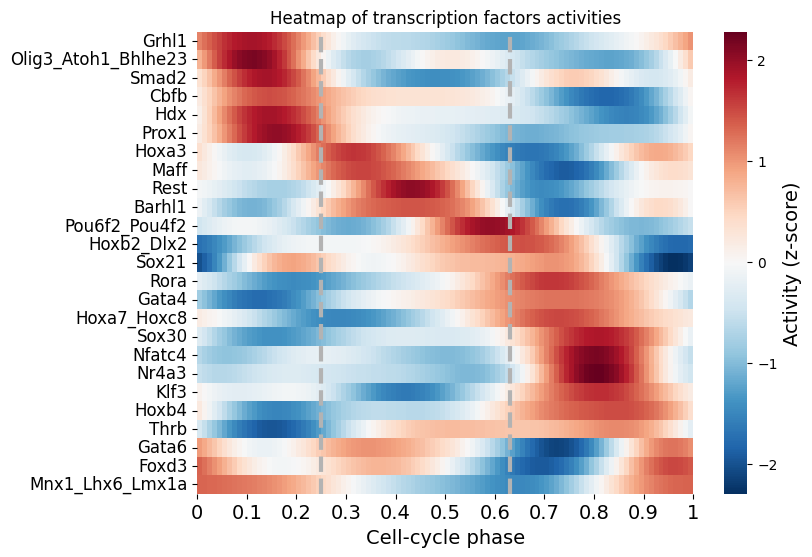

In [10]:
#Heatmap of BPs activity along cell cycle
tf_displayed = plot_heatmap(A1, ylabels=tf_names, display_limit=25)
print(tf_displayed)

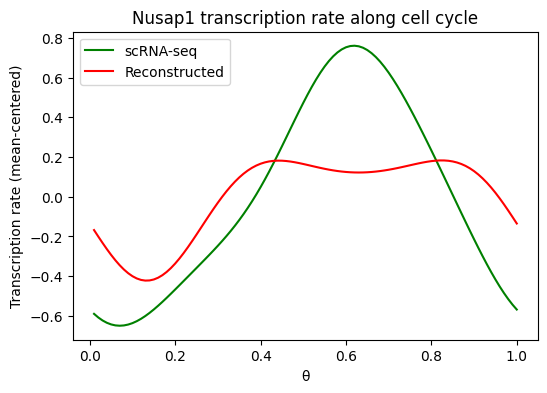

Test


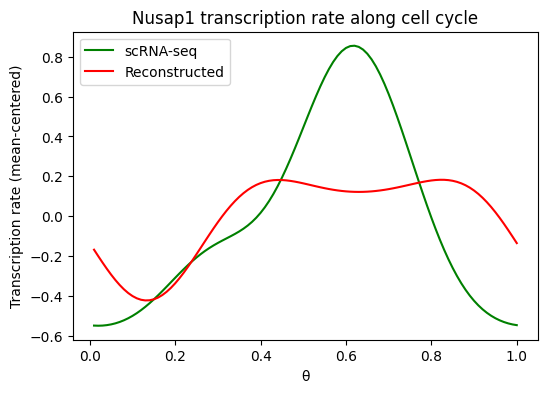

In [11]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 20
#print("Train")
plot_rate_comparison(targetnames, alpha1_norm, R1, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, alpha2_norm, R1, process, theta_smooth, target_nb=n)

In [12]:
#### APPENDIX

In [13]:
# Calculate z-values error bars for activities

def compute_covariance_matrix(N_norm, lam):
    """
    Computes the inverse term common to all cells: inv(N_norm.T @ N_norm + lam I).
    This will later be scaled by sigma^2 per cell.
    """
    M = N_norm.T @ N_norm
    I = np.eye(M.shape[0])
    inv_term = inv(M + lam * I)
    return inv_term

def compute_residual_variance(alpha_norm, N_norm, A):
    """
    Computes the residual variance (sigma^2) per cell.
    For each cell (each column in alpha_norm), calculate the mean squared error
    between the observed alpha_norm and the predicted values from N_norm @ A.
    """
    residuals = alpha_norm - (N_norm @ A)
    sigma2 = np.mean(residuals**2, axis=0)  # one value per cell
    return sigma2

def get_z_values(alpha_norm, N_norm, A, best_lam):
    # Compute residual variance per cell
    sigma2 = compute_residual_variance(alpha_norm, N_norm, A)
    
    # Compute the inverse term (common for all cells) for covariance estimation
    inv_term = compute_covariance_matrix(N_norm, best_lam)
    
    # For each cell, compute the standard errors for each motif activity.
    n_motifs, n_cells = A.shape
    error_bars = np.zeros((n_motifs, n_cells))
    for j in range(n_cells):
        # Standard error for each motif m in cell j: sqrt(diag(inv_term) * sigma2[j])
        error_bars[:, j] = np.sqrt(np.diag(inv_term) * sigma2[j])
    
    # Compute z-values for each motif and cell
    z_values = A / error_bars
    return z_values

#z_values = get_z_values(alpha_norm, N_norm, A, best_lam)